In [1]:
using QuantumCollocation
using NamedTrajectories
using TrajectoryIndexingUtils
using Flux
using ReinforcementLearning
using IntervalSets
using LinearAlgebra
using Base
using Distributions
using Statistics
using Printf
using Reexport
using Revise
using DomainSets
using CairoMakie
using IterTools

includet("PPO.jl")
includet("AIRL.jl")
includet("GateEnvs.jl")

In [2]:
RZ_traj = load_traj("RZ_pretrained.jld2")

const Units = 1e9
const MHz = 1e6 / Units
const GHz = 1e9 / Units
const ns = 1e-9 * Units
const μs = 1e-6 * Units
;


# Operators
const Paulis = Dict(
    "I" => Matrix{ComplexF64}([1 0; 0 1]),
    "X" => Matrix{ComplexF64}([0 1; 1 0]),
    "Y" => Matrix{ComplexF64}([0 im; -im 0]),
    "Z" => Matrix{ComplexF64}([1 0; 0 -1]),
)

rz_op(theta) = exp(-im/2 * theta[1] * Paulis["Z"]);

RZ = Gate(1,rz_op)

H_drives = [
     Paulis["X"],Paulis["Y"]
]
system = QuantumSystem(H_drives);
t_f = 10* ns
n_steps = 51
times = range(0, t_f, n_steps)  # Alternative: collect(0:Δt:t_f)
n_controls=1
n_qubits=1;
Δt = times[2] - times[1]

N = 11
;

In [3]:
Pretraining_Env = GatePretrainingEnv(
                                    system,
                                    n_steps,
                                    RZ,
                                    Δt,
                                    N,
                                    RZ_traj;
                                    dda_bound=1.5
                                    )
random_𝒫 = ActorCriticPolicy(Pretraining_Env)
pretraining_bc_𝒫 = ActorCriticPolicy(Pretraining_Env)

ActorCriticPolicy(Chain(Dense(14 => 128, tanh), Dense(128 => 128, tanh)), Dense(128 => 2, tanh), Dense(128 => 1, log_std_clip), Chain(Dense(14 => 128, tanh), Dense(128 => 128, tanh), Dense(128 => 1)))

In [4]:
infid_data = policy_sample(Pretraining_Env,random_𝒫,100)

100-element Vector{Float64}:
 0.16423503729485533
 0.8483124031827752
 0.06038754446203776
 0.7472309460794633
 0.17207548211686163
 0.49728582269280164
 0.2881051897944181
 0.47194178794102193
 0.24647888794251438
 0.7049695121392612
 0.13826360990546127
 0.8479057521891838
 0.25369794354130204
 ⋮
 0.38818441653316904
 0.7097310971959374
 0.9011167477497684
 0.517056400137546
 0.21540791491768974
 0.06208638375415776
 0.0961785270982548
 0.3191493925588369
 0.6914483500468522
 0.8617649906359928
 0.436151339167562
 0.127430633389919

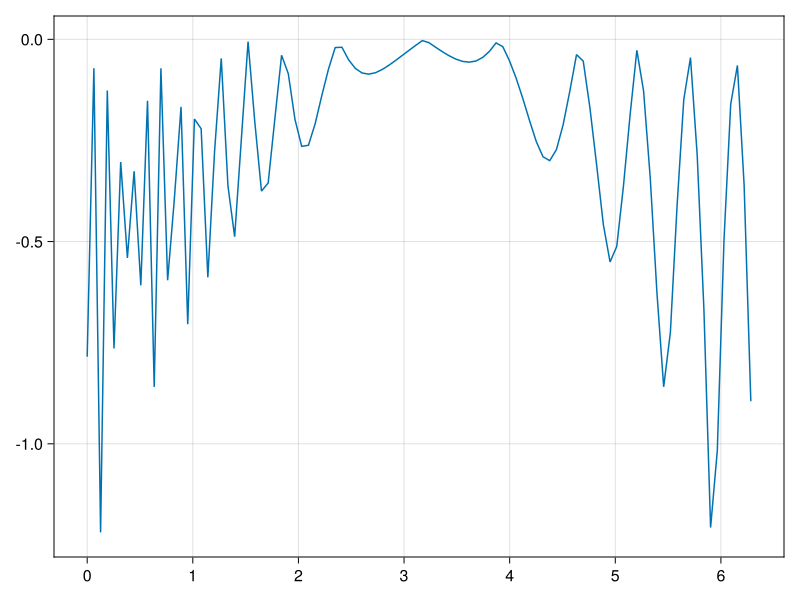

In [5]:
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax,range(0,2π,length(infid_data)),log10.(infid_data))
fig

In [6]:
save_policy(random_𝒫,"initial_policy.jld2")

In [7]:
expert_states = Vector{Vector{Float32}}()
expert_acts = Vector{Vector{Float32}}()
expert_new_states = Vector{Vector{Float32}}()
for idx in 1:11
    for t in 1:48
        angle = range(0,2*pi,11)[idx]
        a = RZ_traj[Symbol("a"*string(idx))][:,t]
        da = RZ_traj[Symbol("da"*string(idx))][:,t]
        dda = RZ_traj[Symbol("dda"*string(idx))][:,t]
        U = RZ_traj[Symbol(Unicode.normalize("Ũ⃗"*string(idx)))][:,t]
        push!(expert_states, vcat(U,da,a,[t/51],angle))
        push!(expert_acts, dda)
        if(t>1)
          push!(expert_new_states, expert_states[end])
        end
        if(t==48)
            angle = range(0,2*pi,11)[idx]
            a = RZ_traj[Symbol("a"*string(idx))][:,51]
            da = RZ_traj[Symbol("da"*string(idx))][:,51]
            dda = RZ_traj[Symbol("dda"*string(idx))][:,51]
            U = RZ_traj[Symbol(Unicode.normalize("Ũ⃗"*string(idx)))][:,51]
            push!(expert_new_states, vcat(U,da,a,[49/51],angle))

        end
    end
end
mean(mean.([abs2.(x) for x in (random_𝒫.mean_network.(random_𝒫.feature_network.(expert_states))-expert_acts)]))

0.15472767f0

In [8]:
behavior_clone(pretraining_bc_𝒫,expert_states,expert_acts;epochs=75000,η=5f-5) 

Epoch 100
Loss: 0.0090613
Epoch 200
Loss: 0.0061239
Epoch 300
Loss: 0.0049937
Epoch 400
Loss: 0.0042796
Epoch 500
Loss: 0.0036675
Epoch 600
Loss: 0.0032185
Epoch 700
Loss: 0.0027076
Epoch 800
Loss: 0.0023405
Epoch 900
Loss: 0.0021034
Epoch 1000
Loss: 0.0020550
Epoch 1100
Loss: 0.0018353
Epoch 1200
Loss: 0.0015985
Epoch 1300
Loss: 0.0013684
Epoch 1400
Loss: 0.0013155
Epoch 1500
Loss: 0.0011950
Epoch 1600
Loss: 0.0012977
Epoch 1700
Loss: 0.0012161
Epoch 1800
Loss: 0.0011396
Epoch 1900
Loss: 0.0012314
Epoch 2000
Loss: 0.0010664
Epoch 2100
Loss: 0.0010837
Epoch 2200
Loss: 0.0009735
Epoch 2300
Loss: 0.0009074
Epoch 2400
Loss: 0.0012217
Epoch 2500
Loss: 0.0010450
Epoch 2600
Loss: 0.0009114
Epoch 2700
Loss: 0.0007797
Epoch 2800
Loss: 0.0010026
Epoch 2900
Loss: 0.0010121
Epoch 3000
Loss: 0.0008252
Epoch 3100
Loss: 0.0008077
Epoch 3200
Loss: 0.0008895
Epoch 3300
Loss: 0.0010756
Epoch 3400
Loss: 0.0006428
Epoch 3500
Loss: 0.0007909
Epoch 3600
Loss: 0.0007215
Epoch 3700
Loss: 0.0007552
Epoch 3800

In [9]:
mean(mean.([abs2.(x) for x in (pretraining_bc_𝒫.mean_network.(pretraining_bc_𝒫.feature_network.(expert_states))-expert_acts)]))

0.00021112185f0

In [10]:
infid_data = policy_sample(Pretraining_Env,pretraining_bc_𝒫,100)

100-element Vector{Float64}:
 0.0038237644538059445
 0.004305705839694696
 0.007393369024031982
 0.01270115667825178
 0.019818334309363528
 0.02802840025862352
 0.036285798901716015
 0.04360610846011925
 0.04950284791687498
 0.05409099992327715
 0.05788186188603606
 0.06151348588796668
 0.06558326848087448
 ⋮
 0.3667463725904967
 0.35158929228554703
 0.33308173463243085
 0.31207340365109204
 0.28961478391923046
 0.26676773729778547
 0.24445146387920902
 0.22336709901903884
 0.20398149785913955
 0.18653923270115513
 0.17108400447060934
 0.15749989010684717

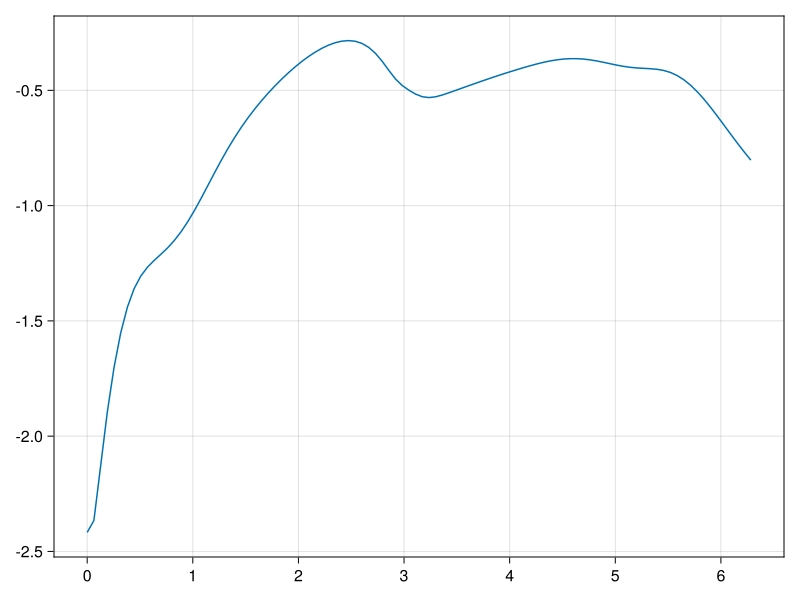

In [11]:
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax,range(0,2π,length(infid_data)),log10.(infid_data))
fig

In [12]:
save_policy(pretraining_bc_𝒫,"bc_policy.jld2")

In [13]:
Flux.params(pretraining_bc_𝒫)

Params([Float32[-0.05597951 -0.029446395 … 0.01586001 -0.00030059548; -0.06138592 -0.026717741 … -0.16226682 -0.003914708; … ; -0.14594214 0.14061481 … -0.12332336 -0.026771326; -0.08826977 -0.21910161 … -0.17985487 0.021621265], Float32[-0.015131692, 0.013501271, -0.018046116, -0.051535573, -0.05896313, 0.009976199, -0.043677874, 0.08472322, -0.09160943, -0.019867428  …  0.09443762, -0.08578928, -0.06029638, 0.047660787, 0.041277707, 0.050629556, 0.096018165, 0.0768031, 0.07880284, 0.02710632], Float32[0.08271435 0.028700307 … 0.03784052 0.24193947; -0.017068384 0.084057294 … -0.023575705 -0.05212227; … ; 0.070134066 0.12938118 … -0.0578883 0.029449252; -0.08695082 0.117012024 … 0.10347787 0.14928092], Float32[-0.15037364, -0.011786547, -0.007450776, -0.0007297254, 0.00022856427, 0.010406215, -0.053297523, -0.0099817775, -0.021271959, 0.001145873  …  -0.015152516, -0.04063016, -0.09825114, -0.0026051954, 0.0005799222, -0.040905416, 0.031590335, -0.02187417, -0.02236836, -0.027123531],